In [6]:
import pandas as pd
from string import punctuation
import re
import datetime
from matplotlib.colors import LinearSegmentedColormap
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
sns.set(font_scale=0.7)

In [7]:
df1 = pd.read_csv('data/test_google_adv.csv')
df1['dt'] = pd.to_datetime(df1['dt'])
df1['dow'] = df1['dt'].dt.day_name().str.upper()
df1['hod'] = df1['dt'].dt.hour
df1.head(3)

,zip_code,dt,line_item_id,impressions,dow,hod
0,60302,2023-09-30 10:00:00,20553552908,40,SATURDAY,10
1,55901,2023-10-14 09:00:00,20553552908,92,SATURDAY,9
2,60639,2023-10-14 16:00:00,20553552908,42,SATURDAY,16


In [8]:
df2 = pd.read_csv('data/test_push_history.csv')
display(df2.head(3))

df2['dow_hod'] = df2['dow_hod'].apply(lambda x: x.replace(" ", ''))
df2['dow_hod'] = df2['dow_hod'].apply(lambda x: re.findall(r"\('([A-Z]+)',\((\d{1,2}),(\d{1,2})\)\)",x))

,line_item_id,dow_hod
0,20557215517,"[('THURSDAY', (15, 22)),('FRIDAY', (15, 22)),(..."
1,20553552908,"[('THURSDAY', (15, 22)),('FRIDAY', (15, 22)),(..."
2,20573098306,"[('MONDAY', (14, 20)),('TUESDAY', (14, 20)),('..."


In [9]:
plan = dict()

for i in range(df2.shape[0]):
    key = df2.loc[i,'line_item_id']
    plan[key] = dict()
    for k in df2.loc[i,'dow_hod']:
        plan[key][k[0]] = range(int(k[1]),int(k[2])+1)

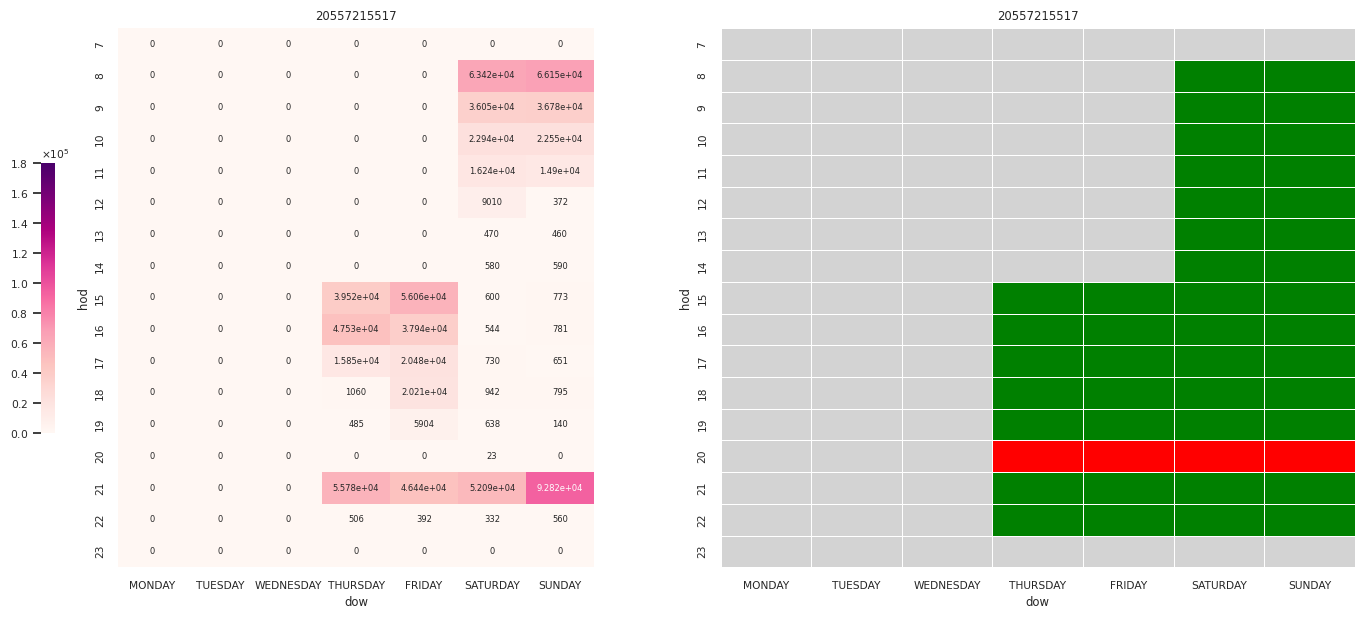

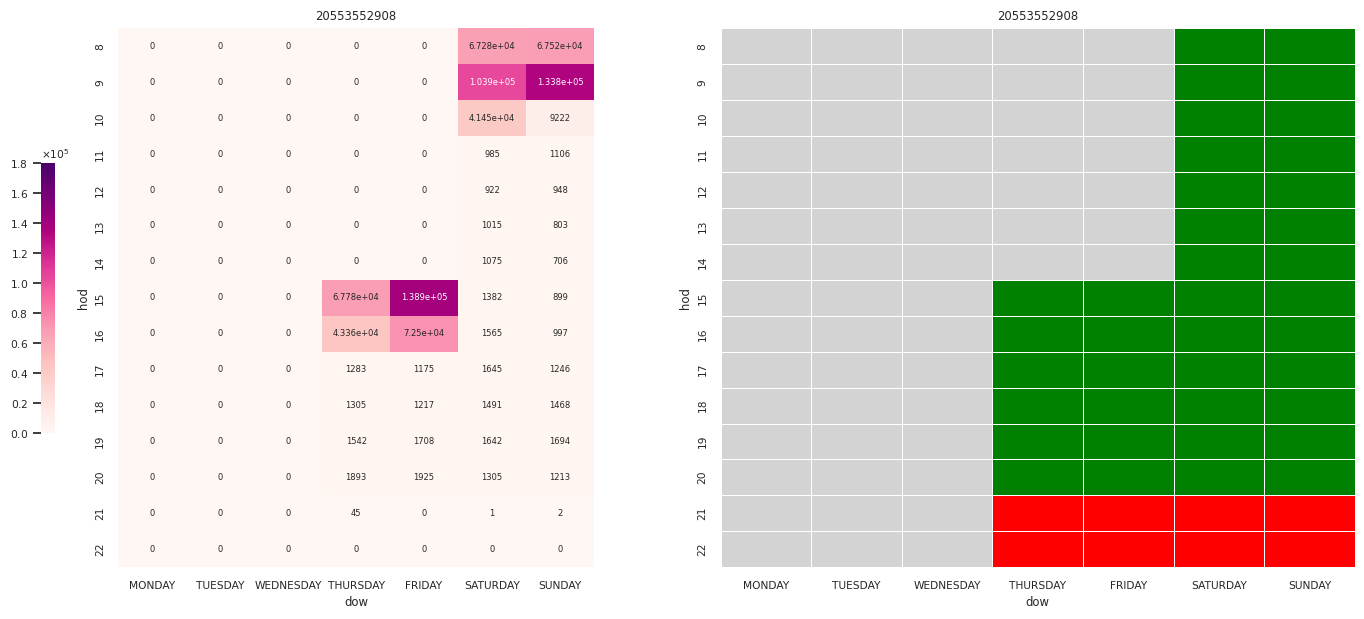

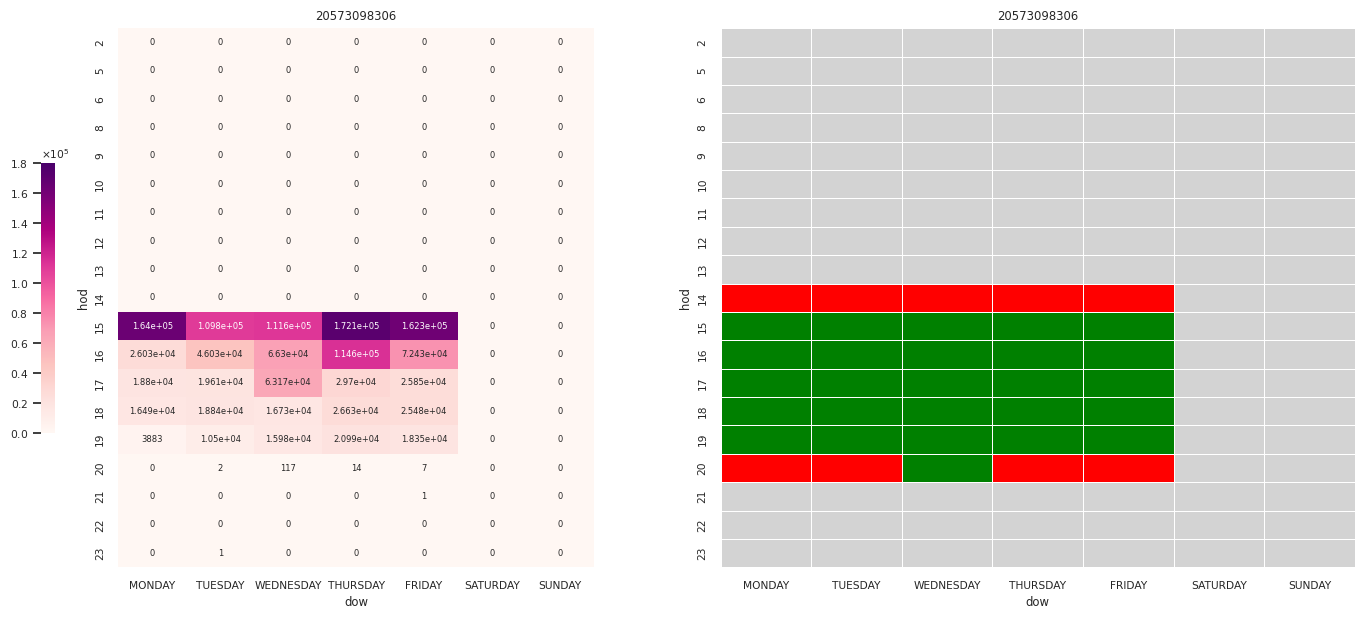

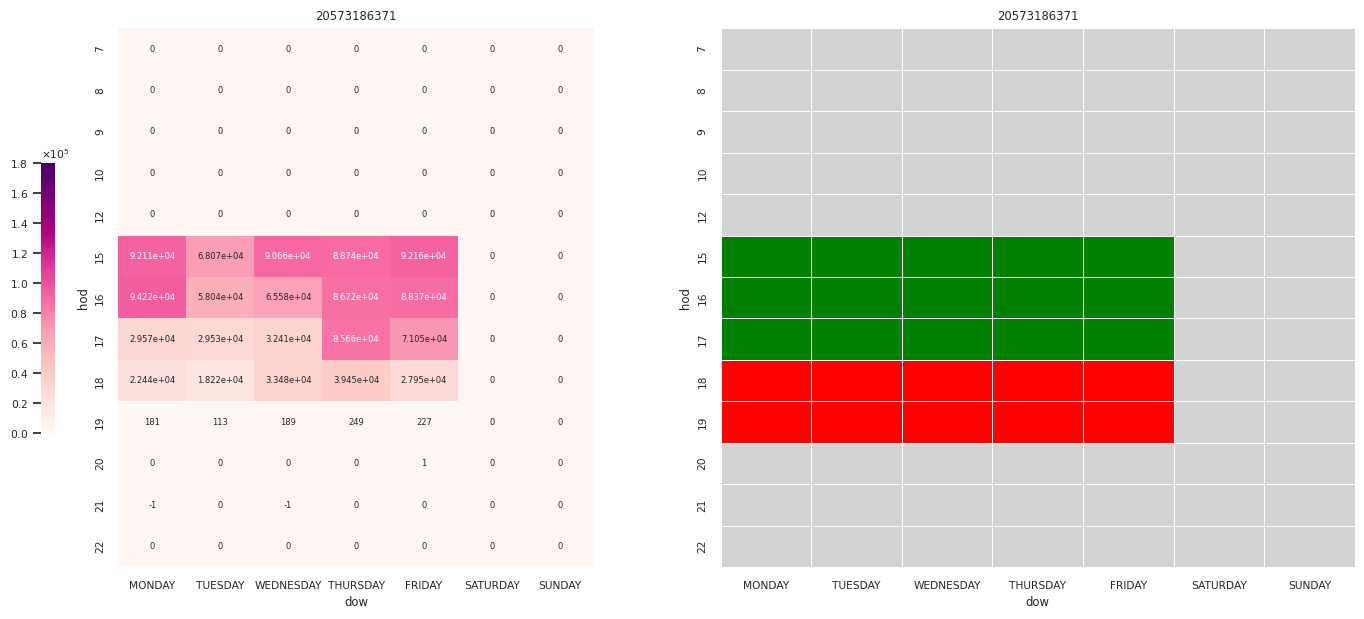

In [10]:
def get_pivots(id):
    pivot = pd.pivot_table(
        df1[(df1['line_item_id']==id)], 
        index='hod', 
        columns='dow', 
        values='impressions', 
        aggfunc='sum').fillna(0)
    col_order = [x.upper() for x in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
    pivot = pivot.reindex(col_order, axis=1).fillna(0)
    
    d = plan[id]
    p = pivot.T
    for i in p.index:
        for c in p.columns:
            #print(i,c)
            if i not in d:
                p.loc[i,c] = 0
                continue    
            if c in d[i] and p.loc[i,c] >= 100:
                p.loc[i,c] = 2
            elif c in d[i] and (p.loc[i,c] < 100 or math.isnan(p.loc[i,c])):
                p.loc[i,c] = 1
            elif c not in d[i] and p.loc[i,c] >= 100:
                p.loc[i,c] = 1
            else:
                p.loc[i,c] = 0
            
    
    f, a = plt.subplots(1,2, figsize=(18, 7))
    
    # 1st table
    formatter = tkr.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2,2))
    sns.heatmap(pivot,
                cmap='RdPu', 
                annot=True, 
                ax=a[0], 
                annot_kws={'fontsize':6},
                cbar_kws = {'use_gridspec':True, 'location':"left", 'shrink':0.5, 'format':formatter},
                vmin=0, vmax=180e3,
                fmt='.4g'
                ).set(title=f'{id}');
    
    # 2nd table
    colors = ['lightgray', "red", "green"] 
    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
    sns.heatmap(p.T, 
                cmap=cmap, 
                linewidths=.5, 
                cbar=False, 
                ax=a[1], 
                ).set(title=f'{id}'); #cbar_kws={"shrink": .5});
    
    return id

for key in plan:
    get_pivots(key)
            